# Benchmark results reporting

## Setup

### Prerequirements
This notebook requires a kernel running Python 3.5+.
You can skip this section if the kernel is already configured.

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn

### Imports and selection of the results directory

In [1]:
from IPython import display as idisplay
import functools as ft
import pandas as pd
import numpy as np
import matplotlib as mp
import seaborn as sb
import warnings

warnings.filterwarnings('ignore')

In [2]:
results_dir = "./stable"
import os
print("current working dir: {}".format(os.getcwd()))
try:
    os.chdir(results_dir)
except:
    pass
os.getcwd()

current working dir: /Users/seb/repos/ml/automlbenchmark


'/Users/seb/repos/ml/automlbenchmark/stable'

## Results

Loading results, formatting and adding columns:
- `result` is the raw result metric computed from predictions at the end the benchmark.
    For classification problems, it is usually `auc` for binomial classification and `logloss` for multinomial classification.
- `error` ensures a standard comparison between tasks: lower is always better.
- `norm_error` is a normalization of `error` on a `[0, 1]` scale, due to `logloss` especially that can take any positive value.

In [3]:
nfolds = 10

def display(fr):
    if type(fr) is pd.Series:
        fr = fr.to_frame()
    if type(fr) is pd.DataFrame:
        idisplay.display(idisplay.HTML(fr.to_html()))
    else:
        print(fr)
        
        
def build_classification_type_map(results_df):
    cp = results_df.loc[(results_df.framework=='constantpredictor')&(results_df.fold==0)]
#     binary_tasks = cp.where(pd.notna(cp.auc))['task'].dropna().tolist()
    return cp.apply(lambda r: pd.Series([r.task, 'binary' if not np.isnan(r.auc) else 'multiclass'], 
                                        index=['task', 'type']), 
                    axis=1,
                    result_type='expand')\
             .set_index('task')['type']\
             .to_dict()    
    

def classification_type(row, type_map):
    return type_map.get(row.task)


def impute_result(row, results_df, res_col='result'):
    if pd.notna(row[res_col]):
        return row[res_col]
    # if all folds are failed or missing, don't impute
    if pd.isna(results_df.loc[(results_df.task==row.task)&(results_df.framework==row.framework)][res_col]).all():
        return np.nan
    # impute with constant predictor corresponding value
    return results_df.loc[(results_df.framework=='constantpredictor')\
                          &(results_df.task==row.task)\
                          &(results_df.fold==row.fold)][res_col]\
                     .item()


def imputed(row):
    return pd.isna(row.result) and pd.notna(row.imp_result)
    

def has_imputed_row(task, framework, results_df):
    sel = results_df.loc[(results_df.task==task)&(results_df.framework==framework)]
    return any(imputed(row) for _, row in sel.iterrows())


def err(row, res_col='result'):
    return 1 - row[res_col] if row[res_col] in [row.auc, row.acc]\
                            else row[res_col]
    
    
def norm_err(row, res_col='result'):
    return 1 - row[res_col] if row[res_col] in [row.auc, row.acc]\
                            else row[res_col] / (1+row[res_col])


all_results = pd.read_csv('results.csv')\
                .replace('constantpredictor_enc', 'constantpredictor')
all_results.task = all_results.task.str.lower()
all_results.framework = all_results.framework.str.lower()
all_results.fold = all_results.fold.apply(int)

all_frameworks = all_results.framework.unique()
all_frameworks.sort()
all_tasks = all_results.task.unique()
all_tasks.sort()
all_folds = all_results.fold.unique()
class_type_map = build_classification_type_map(all_results)


all_done = all_results.set_index(['task', 'fold', 'framework'])
if not all_done.index.is_unique:
    print("Duplicate entries:")
    display(all_done[all_done.index.duplicated(keep=False)].sort_values(by=all_done.index.names))
assert all_done.index.is_unique
all_missing = pd.DataFrame([(task, fold, framework, 'missing') 
                            for task in all_tasks 
                            for fold in range(nfolds)
                            for framework in all_frameworks 
                            if (task, fold, framework) not in all_done.index],
                           columns=[*all_done.index.names, 'info'])\
                          .set_index(all_done.index.names)
assert all_missing.index.is_unique
all_failed = all_results.loc[pd.notna(all_results['info'])]\
                        .set_index(all_done.index.names)
assert all_failed.index.is_unique

# extending the data frame 
all_results = all_results.append(all_missing.reset_index())
all_results['type'] = [classification_type(row, class_type_map) for _, row in all_results.iterrows()]
# all_results['error'] = 1 - all_results['acc']
all_results['error'] = [err(row) for _, row in all_results.iterrows()]
all_results['norm_error'] = [norm_err(row) for _, row in all_results.iterrows()]
all_results['imp_result'] = [impute_result(row, all_results) for _, row in all_results.iterrows()]
all_results['imp_error'] = [impute_result(row, all_results, 'error') for _, row in all_results.iterrows()]

sorted_ints = lambda arr: sorted(list(map(int, arr[~np.isnan(arr)])))

### Tasks list

In [4]:
tasks = all_results.groupby(['task', 'type'])['id']\
                   .unique()\
                   .map(lambda id: id[0])
display(tasks)

,,id
task,type,
adult,binary,openml.org/t/7592
amazon_employee_access,binary,openml.org/t/34539
apsfailure,binary,openml.org/t/168868
australian,binary,openml.org/t/146818
bank-marketing,binary,openml.org/t/14965
bioresponse,binary,openml.org/t/9910
blood-transfusion,binary,openml.org/t/10101
car,multiclass,openml.org/t/146821
christine,binary,openml.org/t/168765


### Completed tasks/folds

In [5]:
done = all_done.reset_index()\
               .groupby(['task', 'framework'])['fold']\
               .unique()
display(done)

### Missing or crashed/aborted tasks/folds

In [6]:
# not_done = pd.DataFrame([(task, framework) for task in all_tasks 
#                                            for framework in all_frameworks 
#                                            if (task, framework) not in done.index],
#                         columns=['task', 'framework'])
# missing = all_results.append(not_done)\
#                      .groupby(['task', 'framework'])['fold']\
#                      .unique()\
#                      .map(sorted_ints)\
#                      .map(lambda arr: sorted(list(set(range(0, nfolds)) - set(arr))))\
#                      .where(lambda values: values.map(lambda arr: len(arr) > 0))\
#                      .dropna()

missing = all_missing.reset_index()\
                     .groupby(['task', 'framework'])['fold']\
                     .unique()
display(missing)

### Failing tasks/folds

In [7]:
# failed = all_results.where(np.isnan(all_results.result))\
#                     .groupby(['task', 'framework'])['fold']\
#                     .unique()\
#                     .map(sorted_ints)

failed = all_failed.reset_index()\
                   .groupby(['task', 'framework'])['fold']\
                   .unique()
display(failed)

## Data reports

### Results summary

Averaging using arithmetic mean over fold `result` or `error`.

In [8]:
res = all_results.groupby(['type', 'task', 'framework'])
mean_res_df = res['imp_result'].mean().unstack()
mean_err_df = res['imp_error'].mean().unstack()
mean_norm_err_df = res['norm_error'].mean().unstack()

imputed_df = all_results.groupby(['type', 'task', 'framework'])['result','imp_result']\
                        .apply(lambda df: any(imputed(row) for _, row in df.iterrows()))\
                        .unstack()

def add_imputed_mark(values, imp, val_type=float):
    formats = dict(float='{:,.6f}{}', int='{0:d}{}', str='{}{}')
    return values.combine(imp, lambda val, imp: '{:,.6g}{}'.format(val, '*' if imp else ''))

#### Results mean

In [9]:
# with pd.option_context('display.float_format', '{:,.6f}*'.format):
display(mean_res_df.combine(imputed_df, add_imputed_mark))

#### Error mean

In [10]:
display(mean_err_df.combine(imputed_df, add_imputed_mark))

In [11]:
mean_res_df.to_csv("result_summary.csv", float_format='%.6g')
mean_err_df.to_csv("error_summary.csv", float_format='%.6g')
mean_norm_err_df.to_csv("norm_error_summary.csv", float_format='%.6g')

### Tasks leaderboard

In [12]:
def rank(errors):
    sorted_errors = np.sort(errors.unique())
    ranks = pd.Series(index=errors.index)
    for idx, value in errors.items():
        try:
            ranks.at[idx] = np.where(sorted_errors == value)[0][0] + 1
        except IndexError:
            ranks.at[idx] = np.nan
    return ranks

In [13]:
task_leaderboard_df = mean_err_df.apply(rank, axis=1, result_type='broadcast').astype(object)
task_leaderboard_df.astype(float).to_csv('tasks_leaderboard.csv', float_format='%.f')
# display(task_leaderboard_df)
display(task_leaderboard_df.combine(imputed_df, ft.partial(add_imputed_mark, val_type=int)))

### Folds leaderboard

In [14]:
folds_err_df = all_results.pivot_table(index=['type','task', 'fold'], columns='framework', values='error')
folds_leaderboard_df = folds_err_df.apply(rank, axis=1, result_type='broadcast').astype(object)
folds_leaderboard_df.astype(float).to_csv('folds_leaderboard.csv', float_format='%.f')
display(folds_leaderboard_df)

## Visualizations

In [15]:
def savefig(fig, path):
    fig.savefig(path, bbox_inches='tight')
    
def task_labels(index):
    max_length = 16
    return index.droplevel('type')\
                .map(lambda x: x if len(x) <= max_length else u'{}…'.format(x[:max_length-1]))\
                .values

### Heatmaps

In [16]:
def draw_heatmap(df, x_labels=True, y_labels=True):
    sb.set(style="whitegrid")
    hm = sb.heatmap(df, xticklabels=x_labels, yticklabels=y_labels, annot=True, cmap='YlOrBr')
    hm.figure.set_size_inches(10, 12)
    hm.figure.set_dpi(120)
    return hm.figure

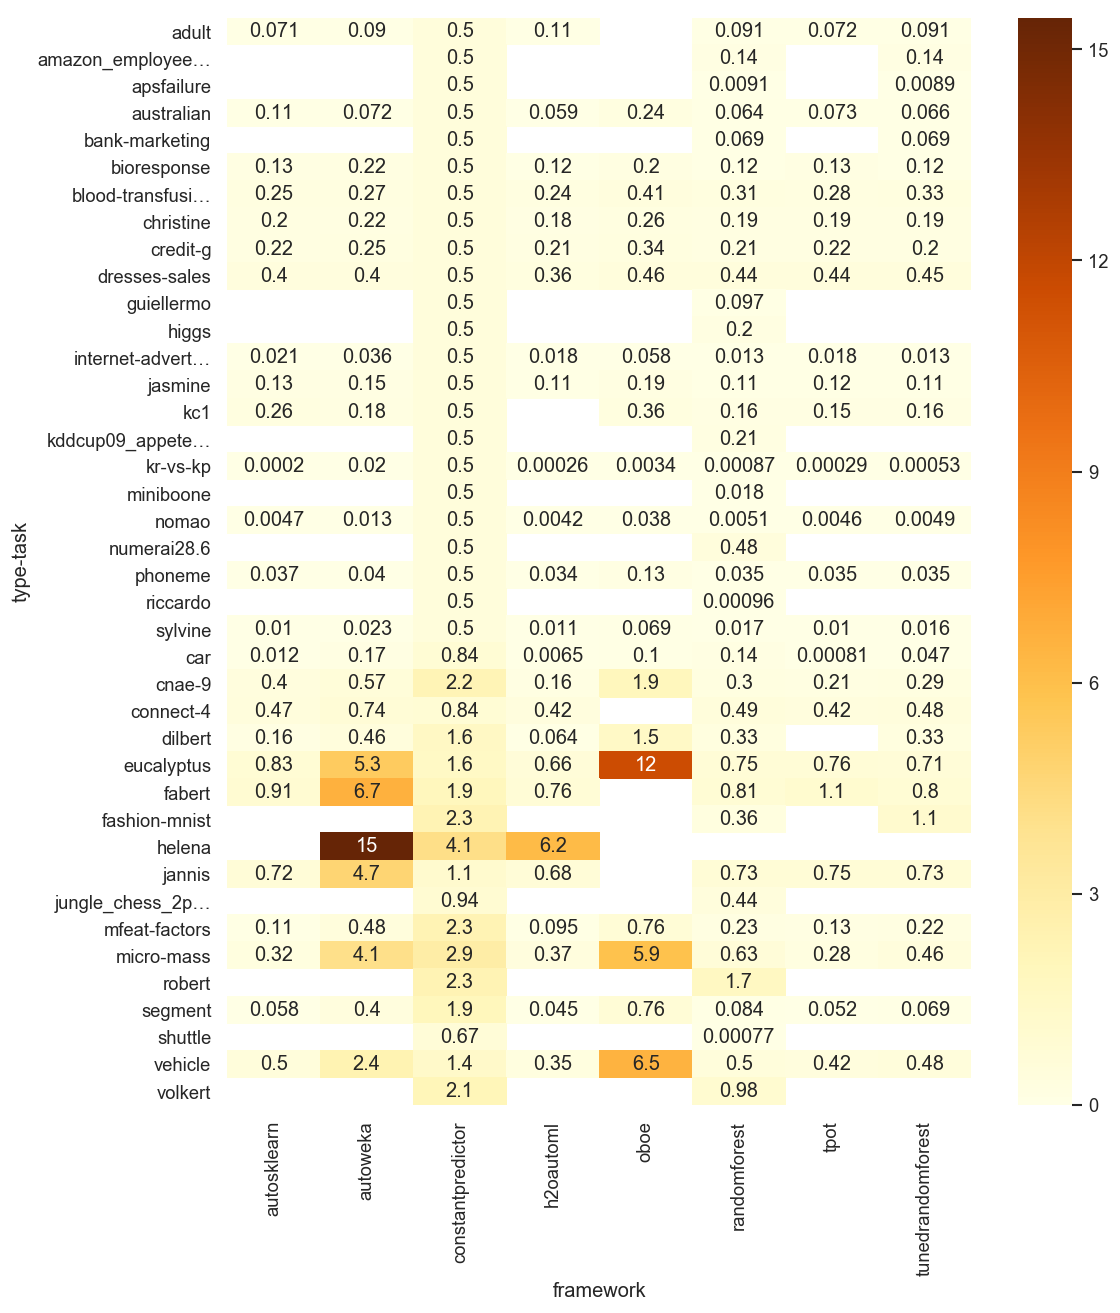

In [17]:
heat_err_fig = draw_heatmap(mean_err_df, y_labels=task_labels(mean_err_df.index))

In [18]:
savefig(heat_err_fig, "heat_error.png")

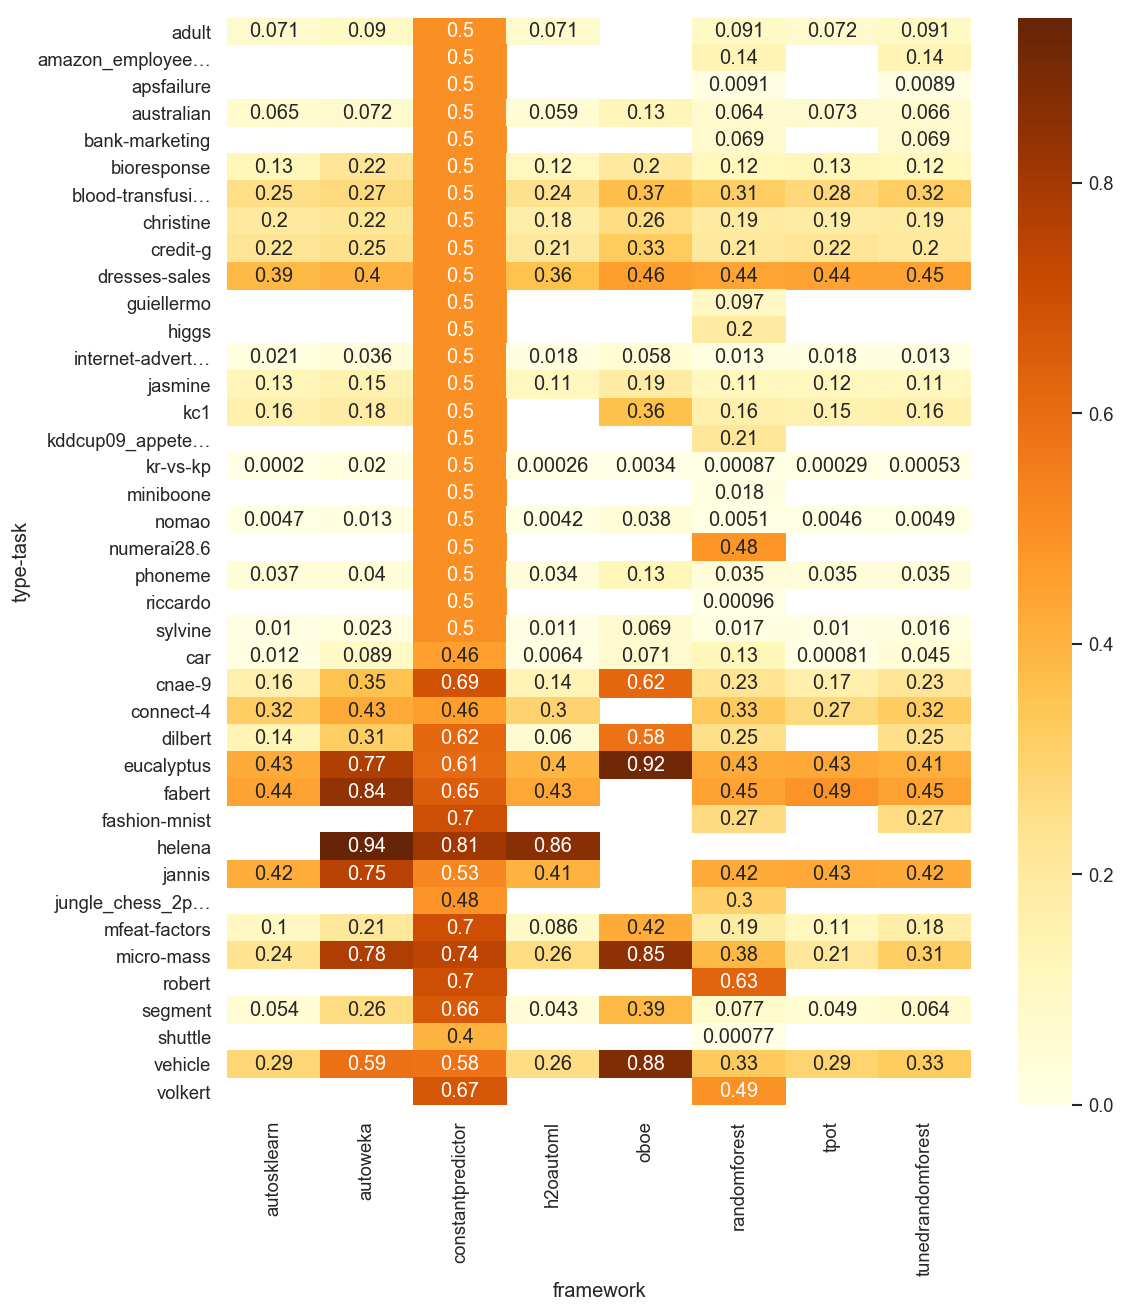

In [19]:
heat_norm_err_fig = draw_heatmap(mean_norm_err_df, y_labels=task_labels(mean_norm_err_df.index))

In [20]:
savefig(heat_norm_err_fig, "heat_norm_error.png")

### Linear plots

In [21]:
def draw_parallel_coord(df, class_column, x_labels=True, yscale='linear', legend_loc='best'):
    parallel_fig = mp.pyplot.figure(dpi=120, figsize=(10, 10))
    axes = pd.plotting.parallel_coordinates(df, 
                                            class_column=class_column, 
                                            colormap='tab10')
    axes.set_yscale(yscale)
    if x_labels is not None:
        axes.set_xticklabels(x_labels)
    axes.tick_params(axis='x', labelrotation=90) 
    handles, labels = axes.get_legend_handles_labels()
    axes.legend(handles, labels, loc=legend_loc)
    return parallel_fig

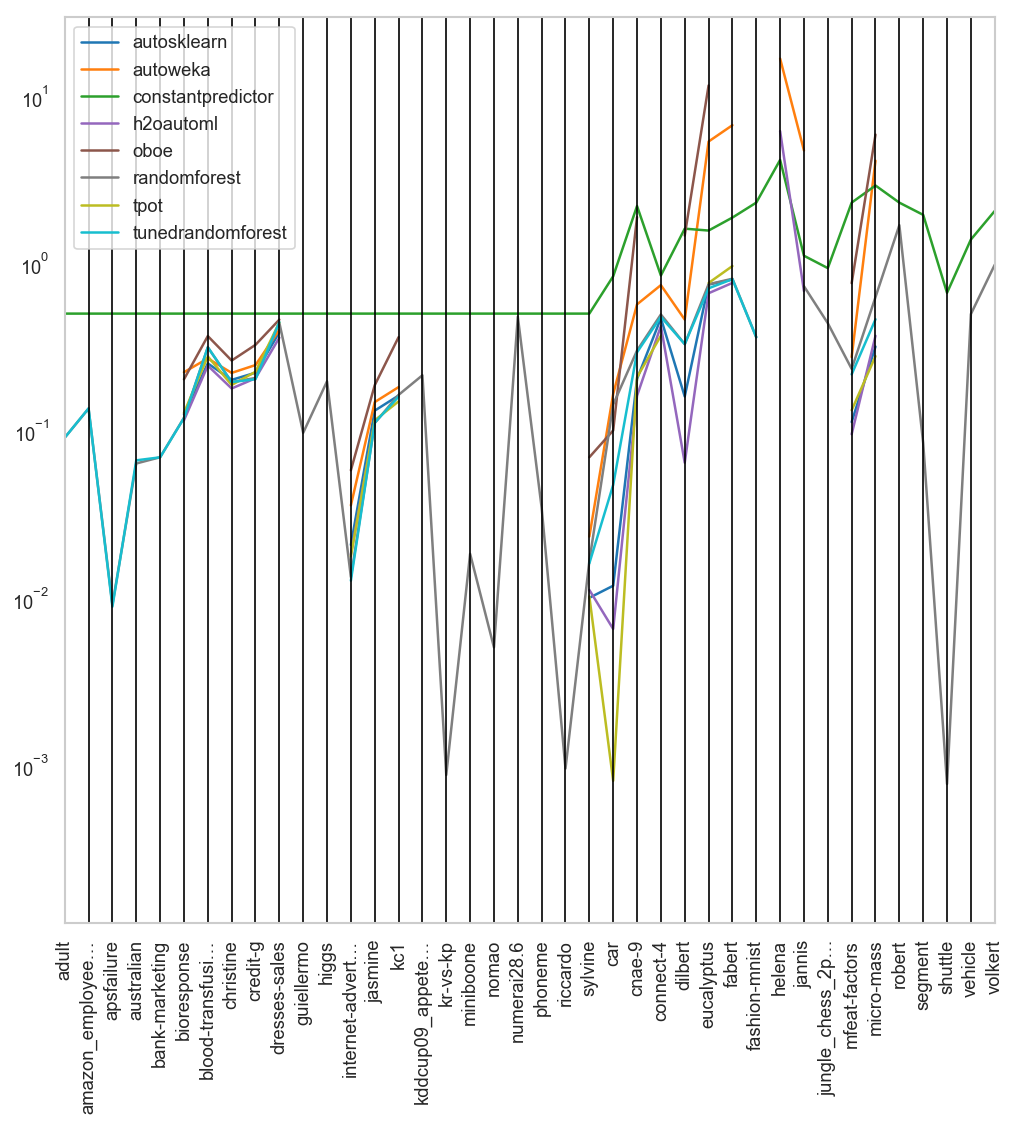

In [22]:
mean_err_parallel_df = res['error'].mean().unstack(['type', 'task'])
mean_err_parallel_df.reset_index(inplace=True)
parallel_err_log_fig = draw_parallel_coord(mean_err_parallel_df, 'framework',
                                           x_labels=task_labels(mean_err_parallel_df.columns.drop('framework')), 
                                           legend_loc='upper left',
                                           yscale='log')

In [23]:
savefig(parallel_err_log_fig, "parallel_coordinates_error_log.png")

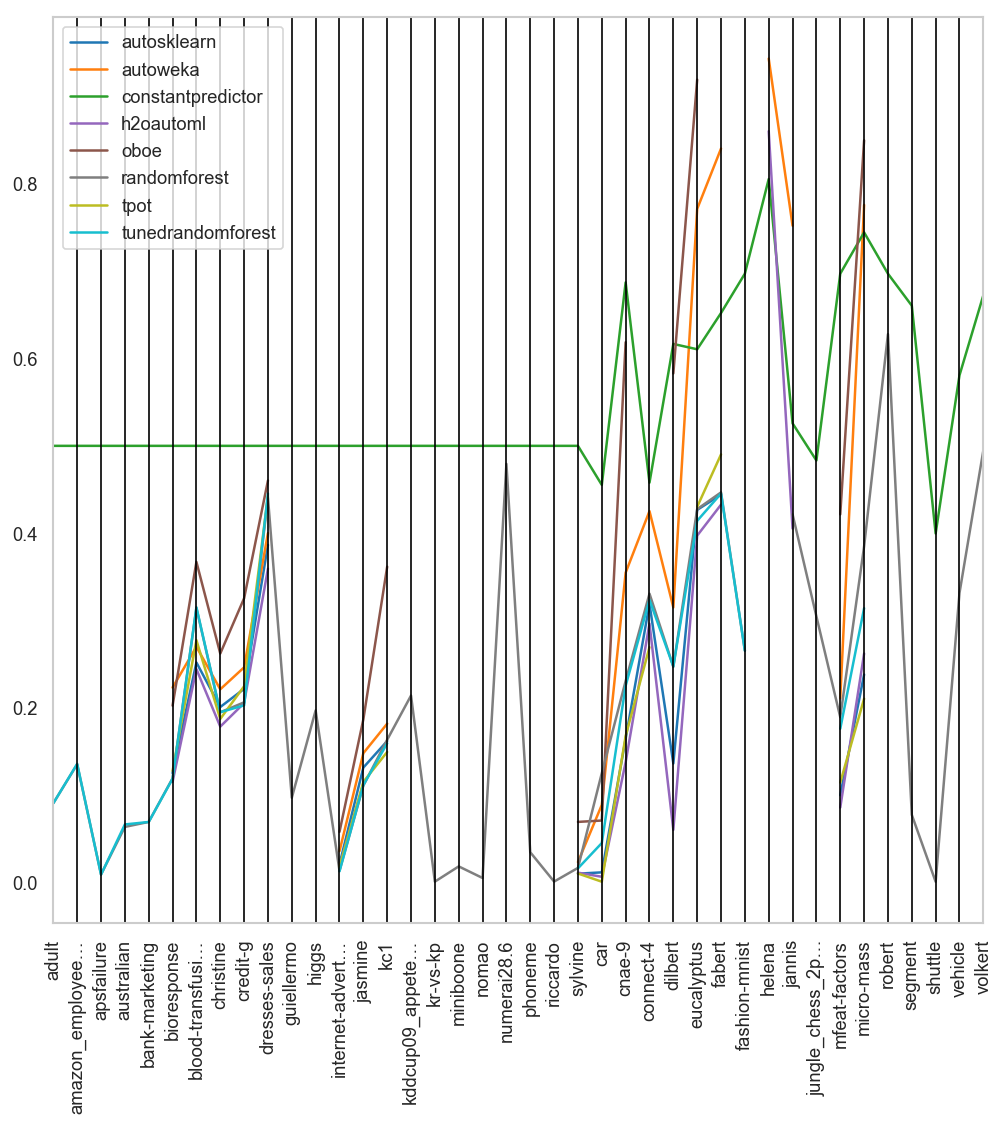

In [24]:
mean_norm_err_parallel_df = res['norm_error'].mean().unstack(['type', 'task'])
mean_norm_err_parallel_df.reset_index(inplace=True)
parallel_norm_err_fig = draw_parallel_coord(mean_norm_err_parallel_df, 'framework',
                                            legend_loc='upper left',
                                            x_labels=task_labels(mean_norm_err_parallel_df.columns.drop('framework')))

### Scatterplots

In [25]:
def draw_stripplot(df, x, y, hue, xscale='linear', xbound=None, y_labels=None, legend_loc='best'):
    sb.set(style="whitegrid")
    # Initialize the figure
    strip_fig, axes = mp.pyplot.subplots(dpi=120, figsize=(10, 15))
    axes.set_xscale(xscale)
    if xbound is not None:   
        axes.set_autoscalex_on(False)
        axes.set_xbound(*xbound)
#     axes.invert_xaxis()
    sb.despine(bottom=True, left=True)

    # Show each observation with a scatterplot
    sb.stripplot(x=x, y=y, hue=hue,
                 data=df, dodge=True, jitter=True,
                 alpha=.25, zorder=1)

    # Show the conditional means
    sb.pointplot(x=x, y=y, hue=hue,
                 data=df, dodge=.5, join=False, palette="tab10",
                 markers="d", scale=.75, ci=None)

    if y_labels is not None:
        axes.set_yticklabels(y_labels)
   # Improve the legend 
    handles, labels = axes.get_legend_handles_labels()
    dist = int(len(labels)/2)
    axes.legend(handles[dist:], labels[dist:], title=hue,
                handletextpad=0, columnspacing=1,
                loc=legend_loc, ncol=1, frameon=True)
    return strip_fig

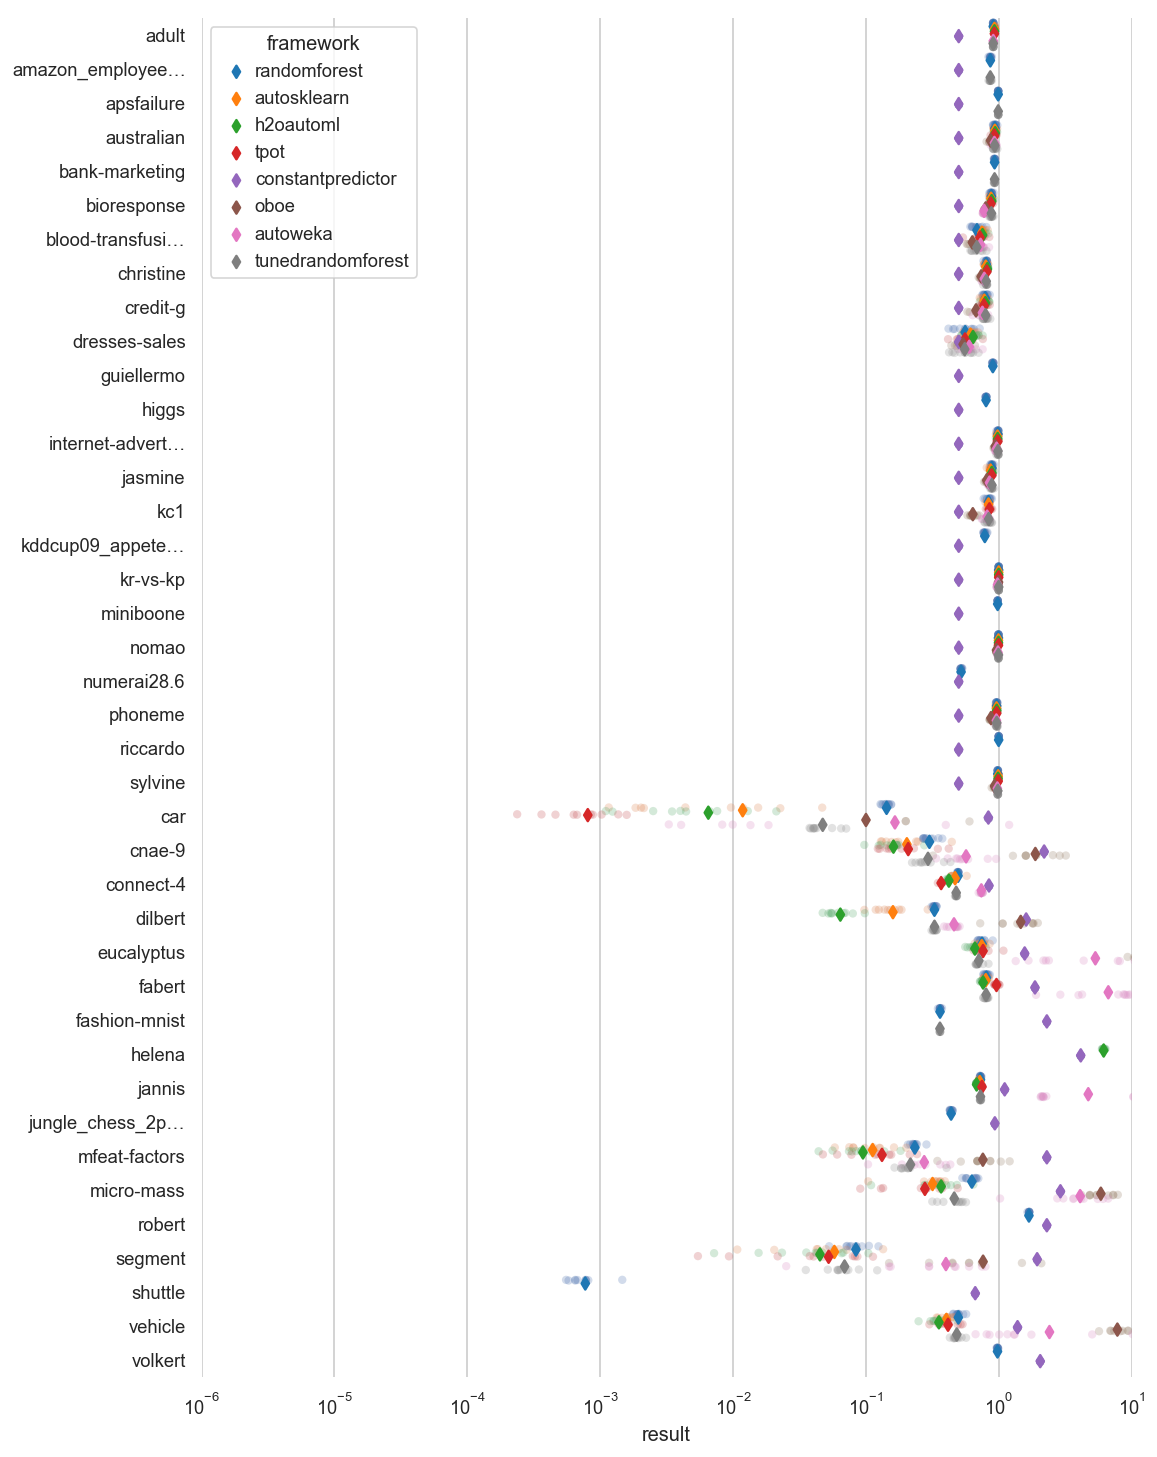

In [26]:
scatterplot_df = all_results.set_index(['type', 'task']).sort_index()
strip_err_log_fig = draw_stripplot(
    scatterplot_df,
    x='result',
    y=scatterplot_df.index,
    hue='framework',
    xscale='log',
    xbound=(1e-6, 10),
    y_labels=task_labels(scatterplot_df.index.unique()),
    legend_loc='upper left'
)

In [27]:
savefig(strip_err_log_fig, "stripplot_error_log.png")

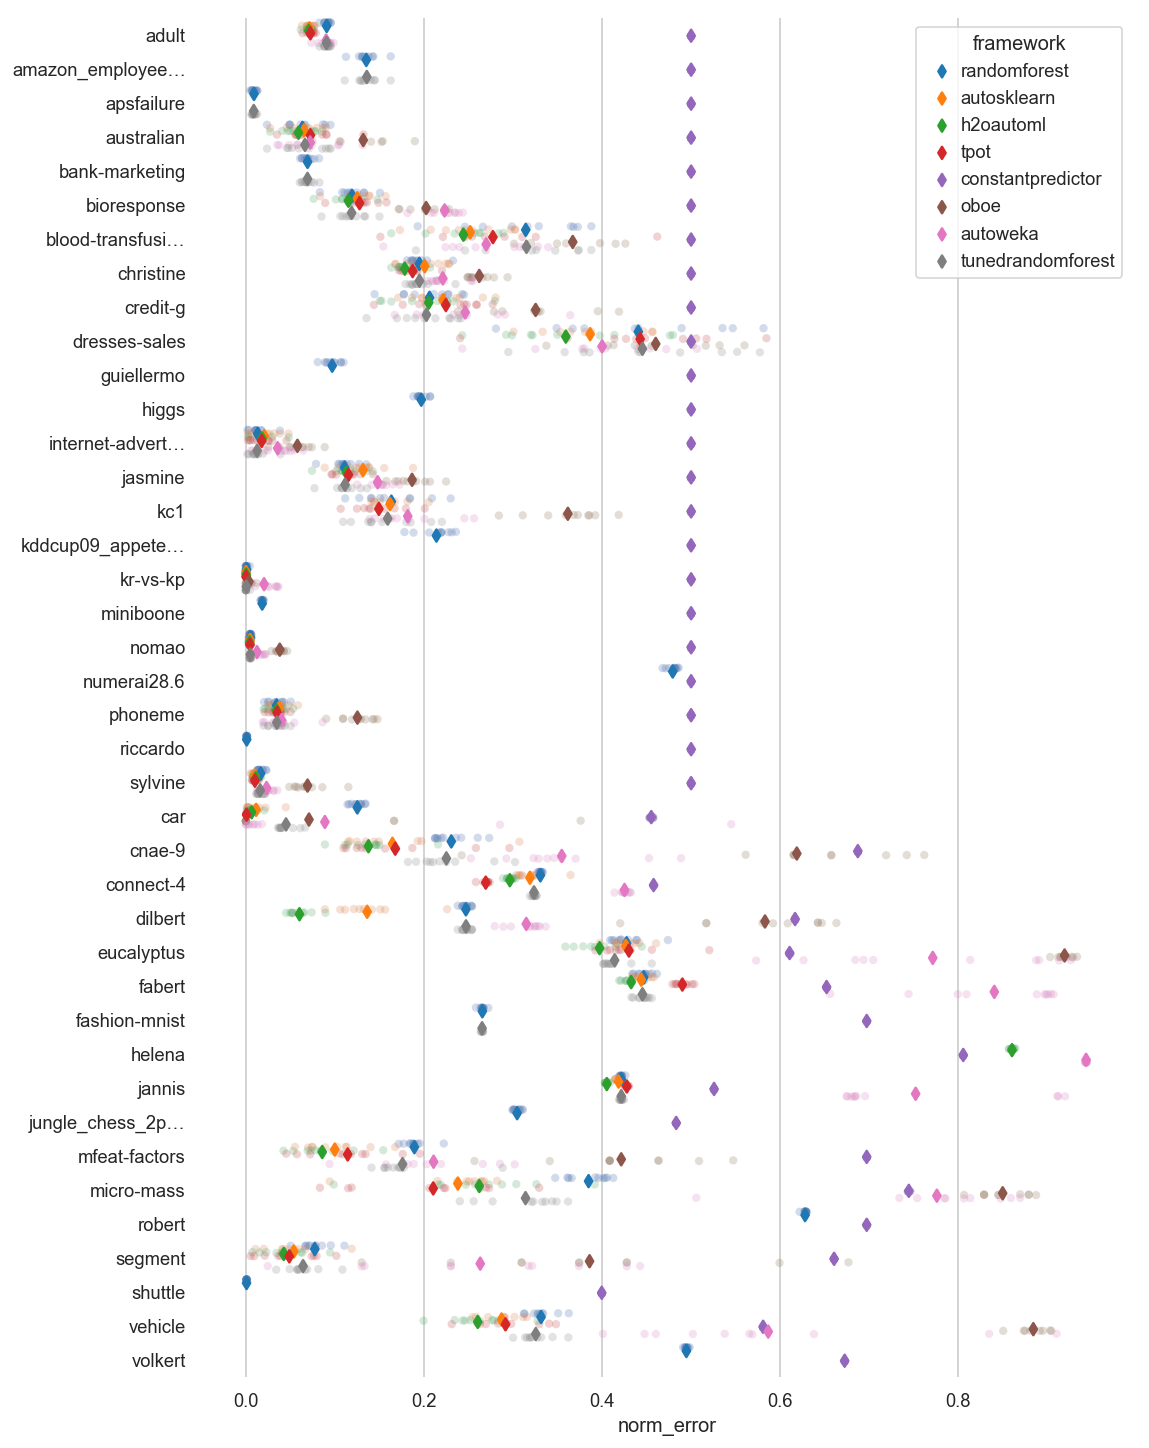

In [28]:
strip_norm_err_fig = draw_stripplot(
    scatterplot_df,
    x='norm_error',
    y=scatterplot_df.index,
    hue='framework',
#     xscale='symlog',
    y_labels=task_labels(scatterplot_df.index.unique()),
    legend_loc='upper right'
)

In [29]:
savefig(strip_norm_err_fig, "stripplot_norm_error.png")

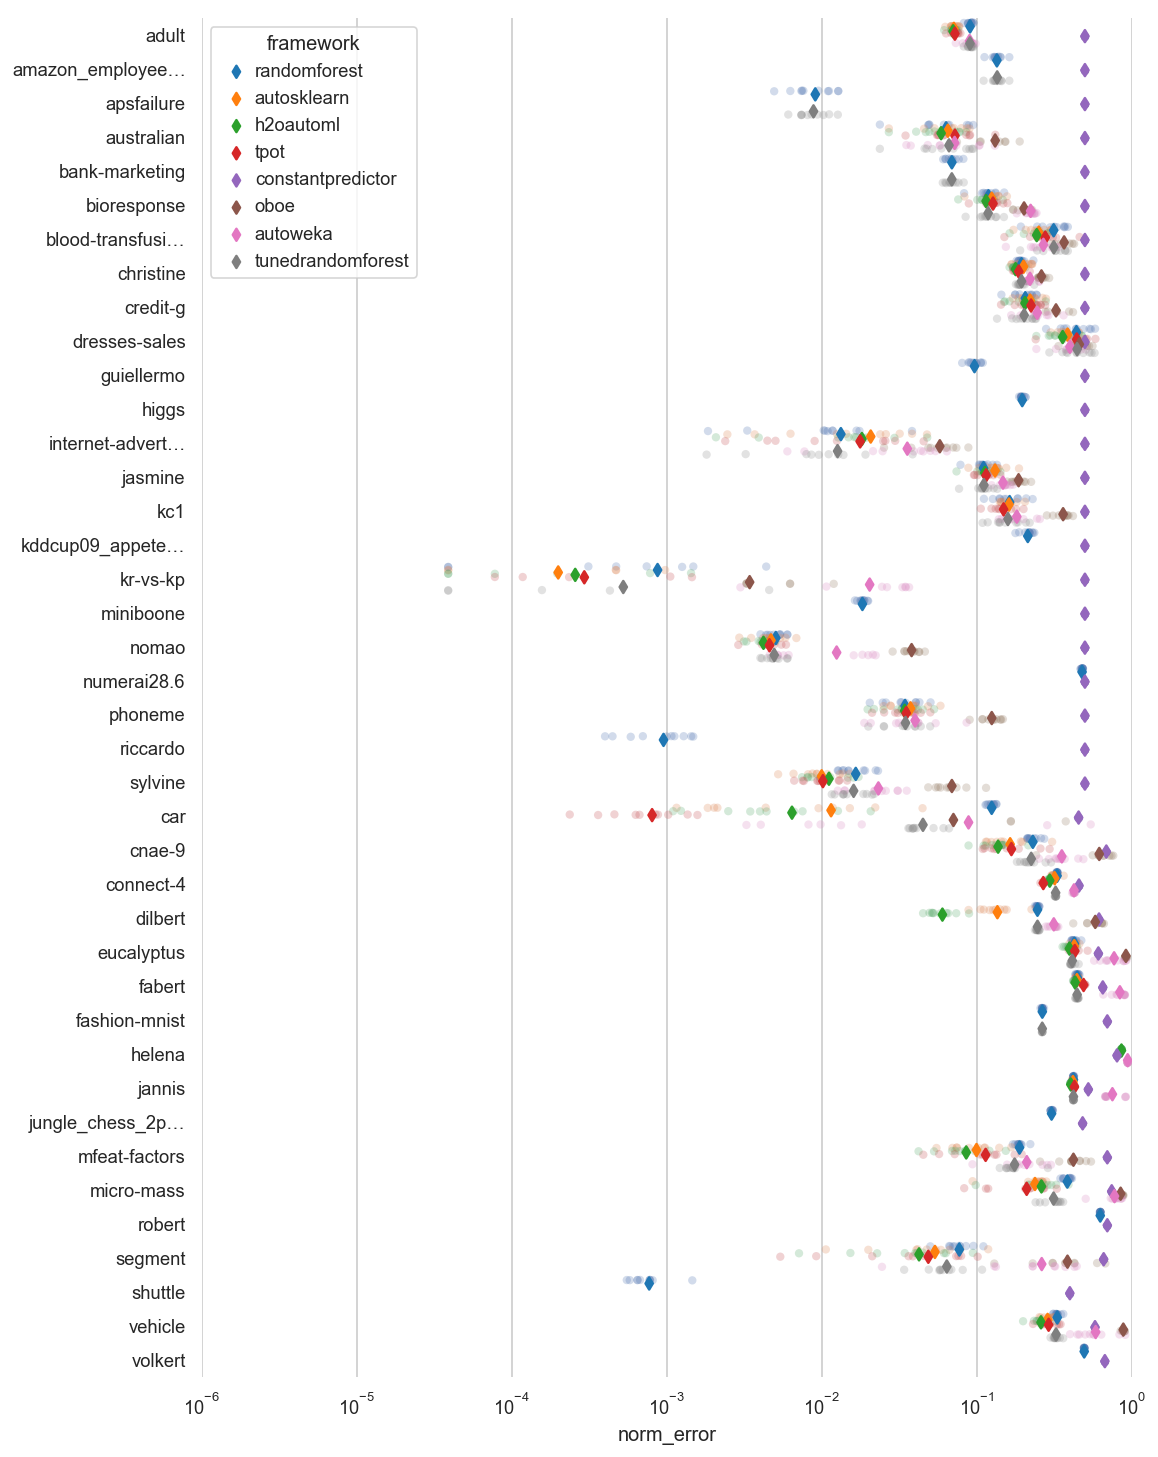

In [30]:
strip_norm_err_log_fig = draw_stripplot(
    scatterplot_df,
    x='norm_error',
    y=scatterplot_df.index,
    hue='framework',
#     xscale='logit',
    xscale='log',
    xbound=(1e-6, 1),
    y_labels=task_labels(scatterplot_df.index.unique()),
    legend_loc='upper left'
)

In [31]:
savefig(strip_norm_err_log_fig, "stripplot_norm_error_log.png")

## Playground

In [32]:
all_results.loc[(all_results.task=='dilbert')&(all_results.framework=='randomforest')];

In [33]:
done.iloc[done.index.get_level_values('framework').isin(['autosklearn', 'h2oautoml', 'tpot'])]\
    .apply(sorted_ints);

In [34]:
failures = all_failed.groupby(['task', 'fold', 'framework'])['info']\
                    .unique();
display(failures)